In [1]:
import pandas as pd
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import os
import cv2
import pandas as pd

plt.style.use('seaborn-bright')

In [2]:
def getDataset(test_size = 0.1):
    labels_path = os.path.join('digits-dataset-MR-AMR', 'train-labels-idx1-ubyte')
    images_path = os.path.join('digits-dataset-MR-AMR', 'train-images-idx3-ubyte')
    labels_path2 = os.path.join('digits-dataset', 'train-labels-idx1-ubyte')
    images_path2 = os.path.join('digits-dataset', 'train-images-idx3-ubyte')

    with open(labels_path,'rb') as lbpath, open(labels_path2, 'rb') as lbpath2:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)
        labels2 = np.frombuffer(lbpath2.read(), dtype=np.uint8, offset=8)

            
    with open(images_path,'rb') as imgpath, open(images_path2, 'rb') as imgpath2:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16).reshape(len(labels), 784)
        images2 = np.frombuffer(imgpath2.read(), dtype=np.uint8, offset=16).reshape(len(labels2), 784)

    labels = np.concatenate((labels, labels2))
    images = np.concatenate((images, images2))
    print('images', images.shape)
    print('labels', labels.shape)

    k = 10 #number of classes
    img_norm = images / 255
    return train_test_split(img_norm, labels, test_size = test_size, random_state = 1), images, labels



images (200000, 784)
labels (200000,)


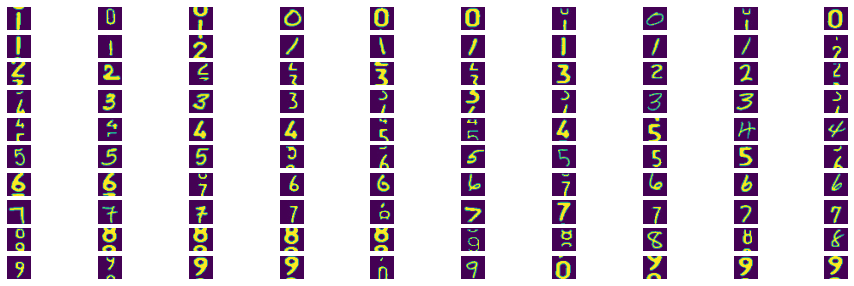

In [3]:
(X_train, y_train, X_test, y_test), images, labels = getDataset()

cols = 10
rows = 10
fig, axs = plt.subplots(rows, cols, figsize=(16, 5))
for i in range(rows):
    img = 0
    l = np.nonzero(labels == i)
    for j in np.random.choice(l[0], cols):
        axs[i, img].axis('off')
        hm = images[j, :].reshape(28, 28)
        axs[i, img].imshow(hm.astype(np.uint8))
        img += 1

In [4]:
k = 10 #number of classes
img_norm = images / 255
X_train, X_test, y_train, y_test = train_test_split(img_norm, labels, test_size = 0.1, random_state = 1)
print('Train dataset:', X_train.shape, y_train.shape)
print('Test dataset:', X_test.shape, y_test.shape)

for i in range(k):
    print('train class ' + str(i), sum(y_train == i))
    print('test class ' + str(i), sum(y_test == i))

Train dataset: (180000, 784) (180000,)
Test dataset: (20000, 784) (20000,)
train class 0 18308
test class 0 2038
train class 1 15336
test class 1 1682
train class 2 21289
test class 2 2397
train class 3 19709
test class 3 2161
train class 4 22137
test class 4 2441
train class 5 17264
test class 5 1925
train class 6 16121
test class 6 1777
train class 7 14333
test class 7 1564
train class 8 16547
test class 8 1860
train class 9 18956
test class 9 2155


In [5]:
def one_hot(y, k):
    return (np.arange(k) == y[:, None]).astype(float)

In [6]:
def softmax(z):
    """
    Z is XW.T = (m,k)
    """
    ex = np.exp(z - np.max(z, axis=1, keepdims=True))
    return ex / ex.sum(axis=1, keepdims=True)

def sigma(z, activation):
    if activation == 'softmax':
        out = softmax(z)
    elif activation == 'tanh':
        out = np.tanh(z)
    else:
        out = z * (z > 0)
    return out

def d_sigma(a, activation):
    if activation == 'tanh':
        out = 1 - a**2
    elif activation == 'softmax':
        out = a * (1 - a)
    else:
        out = 1.*(a > 0)
    return out

In [7]:
def predict(A):
    return np.argmax(A, axis = 1)
def accuracy(A, y):
    y_hat = predict(A)
    tptn = sum(y_hat == y)
    return tptn / y.shape[0]

In [8]:
def cost(A, y):
    m = y.shape[0]
    E = -np.log(A[range(m), y])
    return np.sum(E) / m

#If target is one-hot
def cost2(A, y):
    """
    A: probabilities (m, k)
    y_hot: one-hot encoded (m, k)
    """
    y_hot = one_hot(y, A.shape[1])
    ln = -np.log(A) #(m,k)
    E = y_hot * ln #(m,k)
    return E.sum(axis=1).mean()

In [9]:
class neural_layer():
    def __init__(self, n_conn, n_neur, act_f):
        self.act_f = act_f
        self.b = np.zeros(shape=(1, n_neur))
        self.W = np.random.randn(n_conn, n_neur) * np.sqrt(2 / (n_conn + n_neur)).astype(np.longdouble)


In [10]:
def create_nn(topology, act_f):
    nn = []
    for l, layer in enumerate(topology[:-1]):
        nn.append(neural_layer(topology[l], topology[l+1], act_f))
    return nn

In [11]:
def forward2(neural_net, X):
    out = [(None, X)] # [(Z1, A1), (Z2, A2), ..., (ZN, AN)]
    for l, layer in enumerate(neural_net):
        x = out[-1][1] # A from last output
        # z = x @ neural_net[l].W.T + neural_net[l].b.T
        # print(x.shape, neural_net[l].W.shape, neural_net[l].b.shape)
        z = x @ neural_net[l].W + neural_net[l].b

        if l + 1 == len(neural_net): # if it's last layer, use softmax
            a = sigma(z, 'softmax')
            out.append((z, a))
        else:
            a = sigma(z, neural_net[l].act_f)
            out.append((z, a))
    return out

In [12]:
def backward2(neural_net, out, Y, alpha, lmbda):
    derivatives = [] # [(db, dW)]
    deltas = []
    for l in reversed(range(0, len(neural_net))):
        z = out[l][0]
        a = out[l][1]
        _a = out[l+1][1]
        m = a.shape[0]
        if l == len(neural_net) - 1:
            _a[range(a.shape[0]), Y] -= 1
            _delta = _a / m
            dW = np.dot(_delta.T, a)
            db = np.sum(_delta, axis=0, keepdims=True).T
            delta = d_sigma(a,neural_net[l].act_f) * np.dot(_delta, neural_net[l].W.T)
            derivatives.insert(0, (db, dW))
            deltas.insert(0, delta)
            
        else:            
            dW2 = np.dot(deltas[0].T, a)
            db2 = np.sum(deltas[0], axis=0, keepdims=True).T
            delta = d_sigma(a,neural_net[l].act_f) * np.dot(deltas[0], dW2)
            derivatives.insert(0, (db2, dW2))
            deltas.insert(0, delta)


        neural_net[l].W = neural_net[l].W - alpha * (derivatives[0][1].T + lmbda / m * neural_net[l].W)
        neural_net[l].b = neural_net[l].b - alpha * derivatives[0][0]        

    return neural_net


In [13]:
def train(topology, activation, X, Y, alpha, lmbda, epochs):
    neural_net = create_nn(topology, activation)
    print("##############")
    J = {}

    for i in range(epochs):
        out = forward2(neural_net, X)
        J[i] = cost(out[-1][1], Y)
        derivatives = [] # [(db, dW)]
        deltas = []
        for l in reversed(range(0, len(neural_net))):
            z = out[l][0]
            a = out[l][1]
            _a = out[l+1][1]
            m = a.shape[0]
            if l == len(neural_net) - 1:
                _a[range(a.shape[0]), Y] -= 1
                _delta = _a / m
                dW = np.dot(_delta.T, a)
                db = np.sum(_delta, axis=0, keepdims=True).T
                delta = d_sigma(a,neural_net[l].act_f) * np.dot(_delta, neural_net[l].W.T)
                derivatives.insert(0, (db, dW))
                deltas.insert(0, delta)
                
            else:            
                dW2 = np.dot(deltas[0].T, a)
                db2 = np.sum(deltas[0], axis=0, keepdims=True).T
                delta = d_sigma(a,neural_net[l].act_f) * np.dot(deltas[0], dW2)
                derivatives.insert(0, (db2, dW2))
                deltas.insert(0, delta)

            neural_net[l].W = neural_net[l].W - alpha * (derivatives[0][1].T + lmbda / m * neural_net[l].W)
            neural_net[l].b = neural_net[l].b - alpha * derivatives[0][0].T
    
        if i % 10 == 0:
            print('epoch ', i, 'cost ', J[i])

    print('Final cost', J[epochs-1])
    return neural_net, J

##############
epoch  0 cost  2.403862631464691
epoch  10 cost  2.1174459457472046
epoch  20 cost  1.987351686683459
epoch  30 cost  1.8933256794172122
epoch  40 cost  1.8156067758225338
Final cost 1.7544788472892086
Elapsed time 1.261862834294637 minutes
Accuracy 0.49191666666666667


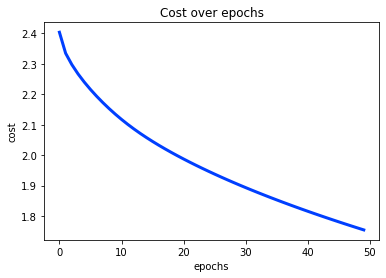

In [14]:
topology = [X_train.shape[1], 10, 10]
activation = 'tanh'
alpha = 0.1 # 0.5
lmbda = 0.3
epochs = 50
start = time.time()
trained_nn, J = train(topology, activation, X_train, y_train, alpha, lmbda, epochs)
end = time.time()
print('Elapsed time', (end - start)/60, 'minutes')
A = forward2(trained_nn, X_train)
acc = accuracy(A[-1][1], y_train)
print('Accuracy', acc)
plt.plot(list(J.keys()), list(J.values()), linewidth=3)
plt.title('Cost over epochs')
plt.xlabel('epochs')
plt.ylabel('cost');

In [15]:
def minibatch(x, y, size):
    np.random.seed(2)
    m, n = x.shape
    idxs = np.arange(m)
    np.random.shuffle(idxs)
    for idx in range(0, m - size + 1, size):
        batch = idxs[idx: idx + size]
        yield x[batch], y[batch]

In [16]:
def SGD_batch(topology, activation, X, Y, alpha, lmbda, epochs, batch_size):
    neural_net = create_nn(topology, activation)
    print("##############")
    J = {}

    for i in range(epochs):
        out = forward2(neural_net, X)
        J[i] = cost(out[-1][1], Y)

        for batch in minibatch(X, Y, size = batch_size):
            a1, y_batch = batch
            out = forward2(neural_net, a1)
            derivatives = [] # [(db, dW)]
            deltas = []
            for l in reversed(range(0, len(neural_net))):
                z = out[l][0]
                a = out[l][1]
                _a = out[l+1][1]
                m = a.shape[0]
                if l == len(neural_net) - 1:
                    _a[range(a.shape[0]), y_batch] -= 1
                    _delta = _a / m
                    dW = np.dot(_delta.T, a)
                    db = np.sum(_delta, axis=0, keepdims=True).T
                    delta = d_sigma(a,neural_net[l].act_f) * np.dot(_delta, neural_net[l].W.T)
                    derivatives.insert(0, (db, dW))
                    deltas.insert(0, delta)
                    
                else:            
                    dW2 = np.dot(deltas[0].T, a)
                    db2 = np.sum(deltas[0], axis=0, keepdims=True).T
                    delta = d_sigma(a,neural_net[l].act_f) * np.dot(deltas[0], dW2)
                    derivatives.insert(0, (db2, dW2))
                    deltas.insert(0, delta)

                neural_net[l].W = neural_net[l].W - alpha * (derivatives[0][1].T + lmbda / batch_size * neural_net[l].W)
                neural_net[l].b = neural_net[l].b - alpha * derivatives[0][0].T
    
        if i % 10 == 0:
            print('epoch ', i, 'cost ', J[i])

    print('Final cost', J[epochs-1])
    return neural_net, J

##############
epoch  0 cost  2.398703471627068
epoch  10 cost  0.7238328116689954
epoch  20 cost  0.7239337516086808
epoch  30 cost  0.7240455507315141
epoch  40 cost  0.7227485380409541
Final cost 0.7227484410562421
Elapsed time 1.3689267039299011 minutes
Accuracy 0.8139611111111111


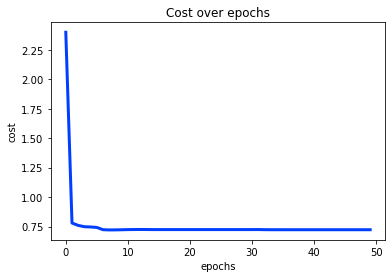

In [17]:
topology = [X_train.shape[1], 10, 10]
activation = 'tanh'
alpha = 0.1 # 0.5
lmbda = 0.3
epochs = 50
batch_size = 30
start = time.time()
trained_nn, J = SGD_batch(topology, activation, X_train, y_train, alpha, lmbda, epochs, batch_size)
end = time.time()
print('Elapsed time', (end - start)/60, 'minutes')
A = forward2(trained_nn, X_train)
acc = accuracy(A[-1][1], y_train)
print('Accuracy', acc)
plt.plot(list(J.keys()), list(J.values()), linewidth=3)
plt.title('Cost over epochs')
plt.xlabel('epochs')
plt.ylabel('cost');

In [18]:
A = forward2(trained_nn, X_test)
acc = accuracy(A[-1][1], y_test)
print('Accuracy', acc)

Accuracy 0.81365


(784,)


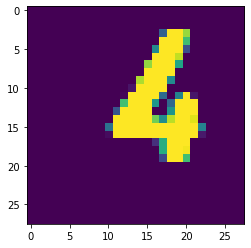

In [19]:
from scipy.ndimage import gaussian_filter

image = cv2.imread('./testtest.png')
image = cv2.resize(image,(28, 28))

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

data = np.asarray(image[:,:,0])
testi=data/255



testi = testi.reshape(28 * 28, )
print(testi.shape)
plt.imshow(gray)

In [20]:
A = forward2(trained_nn, testi)

predict(A[-1][1])

array([6], dtype=int64)

In [21]:
from datetime import datetime


def random_gird_search(runs = 10, hyperparams = {}):

    alphas = hyperparams['alphas']
    epochs = hyperparams['epochs']
    lmbdas  = hyperparams['lmbdas']
    batch_sizes  = hyperparams['batch_sizes']
    topologies = hyperparams['topologies']
    activations = hyperparams['activations']
    algorithms = hyperparams['algorithms']

    np.random.shuffle(alphas)
    np.random.shuffle(epochs)
    np.random.shuffle(lmbdas)
    np.random.shuffle(batch_sizes)
    np.random.shuffle(topologies)
    np.random.shuffle(algorithms)

    runs_accuracy = []
    runs_latest_cost = []
    used_hyperparams = []

    cont = 0

    for r in range(0, runs):
        np.random.seed()
        randomActivation = np.random.randint(0, 2)
        randomAlgorithm = 0 # np.random.randint(0, 2)
        randomTopology = np.random.randint(0, len(topologies)) 
        randomAlphas = np.random.randint(0, len(alphas)) 
        randomEpochs = np.random.randint(0, len(epochs)) 
        randomLmbdas = np.random.randint(0, len(lmbdas)) 
        randomBatches = np.random.randint(0, len(batch_sizes)) 
        print(randomTopology, randomAlphas, randomEpochs, randomLmbdas, randomBatches)

        (X_train, X_test, y_train, y_test), images, labels = getDataset()
        start = time.time()
        # if algorithms[randomAlgorithm] == 'SGD_batch':
        trained_nn, J = SGD_batch(topologies[randomTopology], activations[randomActivation], X_train, y_train, alphas[randomAlphas], lmbdas[randomLmbdas], epochs[randomEpochs], batch_sizes[randomBatches])
        # else:
        #     trained_nn, J = train(topologies[randomTopology], activations[randomActivation], X_train, y_train, alphas[randomAlphas], lmbdas[randomLmbdas], epochs[randomEpochs])
        end = time.time()
        print('Elapsed time', (end - start)/60, 'minutes')
        runs_latest_cost.append(J[epochs[randomEpochs] - 1])
        A = forward2(trained_nn, X_train)
        acc = accuracy(A[-1][1], y_train)
        runs_accuracy.append(acc)
        used_hyperparams.append((topologies[randomTopology], activations[randomActivation], alphas[randomAlphas], lmbdas[randomLmbdas], epochs[randomEpochs], batch_sizes[randomBatches]))
        print('Accuracy', acc)
        print('Run .No', r)

        if cont == 5:
            cont = 0
            now = datetime.now()
            timestamp = datetime.timestamp(now)
            pd.DataFrame(runs_accuracy).to_csv("./grid-search-results/accuracies-" + str(timestamp) +  ".csv")
            pd.DataFrame(used_hyperparams).to_csv("./grid-search-results/used_hypers-" + str(timestamp) + ".csv")
            continue
        
        cont += 1

    return runs_accuracy, used_hyperparams



In [22]:
def getRandomTopologies(x, k, size):
    topologies = []
    for s in range(0, size):
        np.random.seed()
        
        if np.random.randint(0,2) == 1:
            s = np.random.randint(12, 14)
            a = np.random.randint(10, 12)
            tmp = np.arange(a, s, 3)
            tmp = np.insert(tmp, 0, x.shape[1], axis=0)
            tmp = np.insert(tmp, len(tmp), k, axis=0)
            topologies.append(tmp)
        else:
            tmp = np.array([x.shape[1], k])
            topologies.append(tmp)
        

    return np.array(topologies, dtype=object)
print(getRandomTopologies(X_train, 10, 10))


[array([784,  10]) array([784,  11,  10]) array([784,  10])
 array([784,  10]) array([784,  10]) array([784,  10,  10])
 array([784,  10]) array([784,  10,  10]) array([784,  10,  10])
 array([784,  11,  10])]


In [23]:

runs = 200
# getRandomTopologies(X_train, 10, 50)
hyperparams = {
    'alphas': np.arange(0.01, 3, 0.01),
    'epochs': np.arange(10, 50, 10),
    'lmbdas': np.arange(0.1, 3, 0.1),
    'batch_sizes': np.arange(10, 100, 10),
    'topologies': np.array([[784, 30, 10], [784, 100, 10]]),
    'activations': ['tanh', 'relu'],
    'algorithms': ['SGD_batch']
}

# print(hyperparams)
accuracies, used_hypers = random_gird_search(runs, hyperparams)

1809904549
Final cost 26.50758029749706
Elapsed time 1.046483846505483 minutes
Accuracy 0.10949444444444445
Run .No 122
0 49 0 23 7
images (200000, 784)
labels (200000,)
##############
epoch  0 cost  2.4089535260087898
Final cost 30.906093820515103
Elapsed time 0.35151928265889487 minutes
Accuracy 0.07962777777777778
Run .No 123
1 51 2 2 4
images (200000, 784)
labels (200000,)
##############
epoch  0 cost  2.346790670777398
epoch  10 cost  0.28319935221603376
epoch  20 cost  0.2904597691482461
Final cost 0.37271752987957985
Elapsed time 3.1137281616528827 minutes
Accuracy 0.90825
Run .No 124
0 13 1 23 4
images (200000, 784)
labels (200000,)
##############
epoch  0 cost  2.354462093445248
epoch  10 cost  2.304868420854712
epoch  20 cost  2.304868420854712
epoch  30 cost  2.304868420854712
Final cost 2.304868420854712
Elapsed time 2.0912661512692767 minutes
Accuracy 0.11827222222222222
Run .No 125
0 207 2 21 6
images (200000, 784)
labels (200000,)
##############
epoch  0 cost  2.45857121

In [62]:
accuracies

[0.7316722222222222,
 0.0867388888888889,
 0.1684388888888889,
 0.08416666666666667,
 0.10857222222222222,
 0.14416666666666667]

In [108]:
used_hypers

[(array([784,   9,  12,  10]),
  'relu',
  0.001,
  0.401,
  100,
  50,
  'digits-dataset-MR-AMR',
  'SGD_batch'),
 (array([784,  10,  10]),
  'softmax',
  0.201,
  0.381,
  350,
  80,
  'digits-dataset',
  'SGD_batch')]